# Exploration of phonetic embeddings

In this notebook we will try to visualize embeddings of IPA characters and interpret them.
Our phonetic encoding model works at character level. It has learned a different embedding for each IPA character during its training.
We expect embedding of close such as in the IPA graph: 

![IPA Graph](https://d3uxfe7dw0hhy7.cloudfront.net/acip/assets/course/ipachart/IPA2005.png) 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mlflow
import torch
from src.pairing.model.phonetic_siamese import PhoneticSiamese

import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Load model from MLFlow experiment

In [3]:
# model_uri = "C:/Users/simon/Projets/FindingMnemo/mlruns/449760764592553836/eb14dcd397814042aef965683bb7b198/artifacts/model" # mlflow.artifacts.download_artifacts("")
# model = mlflow.pytorch.load_model(model_uri)
# model.eval()

In [4]:
from pathlib import Path

path = Path("../src/pairing/model/model_dict") 

def load_model(path) -> PhoneticSiamese:
    model = PhoneticSiamese()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

model = load_model(path)
cuda_device = torch.device('cuda:0')
cpu_device = torch.device('cpu')
model = model.to(cpu_device)

Get embeddings stored in the model and vocabulary associated with each row.

In [5]:
vocabulary = model.vocabulary
embedding = model.embedding.weight.detach().numpy()

## Visualization of embeddings using UMAP

*"UMAP is a general purpose manifold learning and dimension reduction algorithm."*
We use it in order to keep distances from large dimensions similar while reducing them to 2 dimension so that we can plot them on a graph.

In [6]:
reducer = umap.UMAP()
scaled_embedding = StandardScaler().fit_transform(embedding)
umapped_embedding = reducer.fit_transform(scaled_embedding)
umapped_embedding.shape

(588, 2)

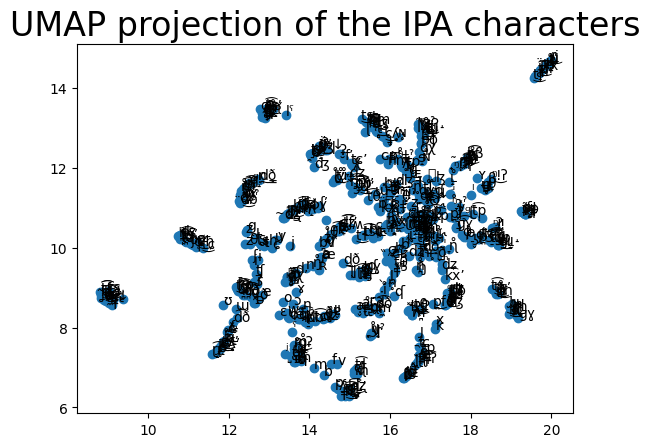

In [7]:
z = umapped_embedding[:, 0]
y = umapped_embedding[:, 1]
d = {x: y for y,x in vocabulary.items()}
fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(range(len(z)-1)):
    ax.annotate(d[i], (z[i], y[i]))

plt.title('UMAP projection of the IPA characters', fontsize=24)
plt.show()

## Visualization of words

In [8]:
import pandas as pd
import numpy as np
chinese_df = pd.read_csv('../src/pairing/dataset/pairing/chinese.csv')
english_df = pd.read_csv('../src/pairing/dataset/pairing/english.csv')

In [9]:
sample_chinese_df = chinese_df.sample(1000)
sample_english_df = english_df.sample(1000)

In [10]:
chinese_phonetics = sample_chinese_df['ipa'].dropna()
english_phonetics = sample_english_df['ipa'].dropna()

In [11]:
model = model.to(cuda_device)

In [12]:
chinese_embeddings = model.encode(chinese_phonetics.values).to(cpu_device).detach().numpy()
english_embeddings = model.encode(english_phonetics.values).to(cpu_device).detach().numpy()
all_embeddings = np.concatenate((chinese_embeddings, english_embeddings), axis=0)
language = ['red']*len(chinese_embeddings) + ['blue']*len(english_embeddings)
word_len = [len(w) for w in chinese_phonetics] + [len(w) for w in english_phonetics]

In [13]:
np.linalg.norm(english_embeddings[:10] - chinese_embeddings[:10])

8.795056

In [14]:
np.linalg.norm(chinese_embeddings[:10] - chinese_embeddings[10:20])

8.402896

In [15]:
chinese_embeddings[:10]

array([[-1.9409204e-01,  2.4275641e+00, -5.4592198e-01, -7.5821419e+00,
        -1.2055168e+00, -2.5834980e+01,  8.7168283e+00,  9.7617226e+00,
         3.6069763e+00,  1.4472818e+00,  9.8797667e-01,  1.3257296e+00,
         6.4002905e+00,  3.2120318e+00, -1.8894043e+00,  5.0456405e+00],
       [-1.2426578e-01,  1.7142816e+00, -3.5899717e-01, -7.0345030e+00,
        -7.6005220e-01, -2.6130716e+01,  9.0892868e+00,  1.0104869e+01,
         3.7846031e+00,  1.2756264e+00,  1.2504804e+00,  6.2616247e-01,
         6.0223956e+00,  3.5370672e+00, -1.7489812e+00,  4.4069052e+00],
       [ 2.2360086e-01,  2.5986116e+00, -1.4435619e-01, -7.3311367e+00,
        -8.8999474e-01, -2.5936266e+01,  8.3395405e+00,  9.9750271e+00,
         4.4106097e+00,  4.5445088e-01,  1.5887036e+00,  9.1492081e-01,
         6.2666035e+00,  3.2796316e+00, -2.0387573e+00,  4.3049965e+00],
       [-6.1732680e-02,  2.3283286e+00, -4.0159240e-01, -7.0143752e+00,
        -1.1618235e+00, -2.6132641e+01,  8.9460516e+00,  1.00

In [16]:
reducer = umap.UMAP()
scaled_embedding = StandardScaler().fit_transform(all_embeddings)
umapped_embedding = reducer.fit_transform(scaled_embedding)
umapped_embedding.shape

(1998, 2)

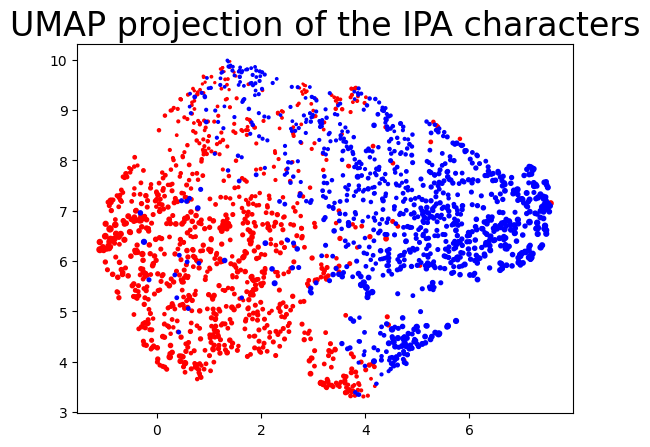

In [17]:
z = umapped_embedding[:, 0]
y = umapped_embedding[:, 1]
d = {x: y for y,x in vocabulary.items()}
fig, ax = plt.subplots()
ax.scatter(z, y, c=language, s=word_len)

# for i, txt in enumerate(range(len(z)-1)):
#     ax.annotate(d[i], (z[i], y[i]))

plt.title('UMAP projection of the IPA characters', fontsize=24)
plt.show()